# Train ViViT Model

In [1]:
from pathlib import Path
dataset_root_path = Path("/media/thibault/DATA/these_thibault/Dataset/data/EgoExo4D/dataset/")

In [2]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 1632


In [3]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
 )
all_video_file_paths[:6]

[PosixPath('/media/thibault/DATA/these_thibault/Dataset/data/EgoExo4D/dataset/train/Early Expert/iiith_cooking_01_1.mp4'),
 PosixPath('/media/thibault/DATA/these_thibault/Dataset/data/EgoExo4D/dataset/train/Early Expert/iiith_cooking_03_1.mp4'),
 PosixPath('/media/thibault/DATA/these_thibault/Dataset/data/EgoExo4D/dataset/train/Early Expert/iiith_cooking_04_1.mp4'),
 PosixPath('/media/thibault/DATA/these_thibault/Dataset/data/EgoExo4D/dataset/train/Early Expert/iiith_cooking_05_3.mp4'),
 PosixPath('/media/thibault/DATA/these_thibault/Dataset/data/EgoExo4D/dataset/train/Early Expert/iiith_cooking_05_5.mp4'),
 PosixPath('/media/thibault/DATA/these_thibault/Dataset/data/EgoExo4D/dataset/train/Early Expert/iiith_cooking_06_1.mp4')]

In [4]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")


Unique classes: ['Early Expert', 'Intermediate Expert', 'Late Expert', 'Novice'].


## Load Model to Finetune

In [26]:
from transformers import VivitImageProcessor, VivitForVideoClassification, TrainingArguments, Trainer
import torch
from torchsummary import summary

model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400").to("cuda")
training_args = TrainingArguments(output_dir="test_trainer")
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model.config.label2id = label2id
model.config.id2label = id2label
model.classifier = torch.nn.Linear(in_features=768, out_features=len(class_labels), bias=True).to("cuda")
model.num_labels = len(class_labels)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {pytorch_total_params}")


Total parameters: 88649476


## Prepare Dataset for Training

In [6]:
import pytorchvideo.data
import os
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)


train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [7]:
print(train_dataset.num_videos, test_dataset.num_videos)

1594 38


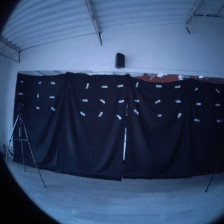

In [8]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [9]:
from transformers import TrainingArguments, Trainer

model_name = "ViViT"
new_model_name = f"{model_name}-finetuned-egoexo4D-subset"
num_epochs = 2
batch_size = 1

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    num_train_epochs=num_epochs,
    learning_rate=1e-4,
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    logging_dir="./logs",
    metric_for_best_model="accuracy",
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [10]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [11]:
import torch
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [12]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [13]:
train_results = trainer.train()

Step,Training Loss


KeyboardInterrupt: 